In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
from marl_aquarium import aquarium_v0
from models.Buffer import Buffer, Pool
from models.PreyPolicy import PreyPolicy
from models.PredatorPolicy import PredatorPolicy
from models.Discriminator import Discriminator

In [ ]:
"""
ToDo's
- Umgang mit Mode Collapse?
- AnyDesk Daten kopieren und processen

- Multi Objective Training - Distance to Predator, Escape Alignment

Hinweis:
- Falls Pretraining mit BC - danach Modell auf CPU schieben
"""

"\nToDo's\n- Umgang mit Mode Collapse?\n- Training auf GPU\n- Gamma bei pred_gain mit tunen\n\n- Discriminator konvergiert werden Output 0.5, heißt er macht Coin-Flip bei jedem Case.\n- Speed Metriken und Velocity Metric bei Scaling und als Input-Vector prüfen!\n- Multi Objective Training:\n\nfitness = disc_reward           + λ1 * ( - |polarization - polarization_expert| )           + λ2 * ( - |distance_to_predator - target_dist| )           + λ3 * ( - |escape_alignment - target_escape| )\n\n"

In [3]:
# Hyperparameters

# generated_trajectories
gt_gen_episodes = 50
gt_clip_length = 30

# Training
num_generations = 61
pred_batch_size = 256
prey_batch_size = 512
gen_dis_ratio = 1

# Polcy Update
num_perturbations = 32
pert_clip_length = 22
sigma = 0.0703153292486112               
gamma = 0.9995             
lr_pred_pin = 0.0007442062051182169
lr_pred_an = 0.00008326162744937111    
lr_prey_pin = 0.00010296057739631855
lr_prey_an = 0.00007160898826391525
lr_prey_pred_pin = 0.0005573836216821976

# Discriminator Update
lr_pred_dis =  1.4355130033773653e-05
lr_prey_dis =  1.0493552789683608e-04
alpha = 0.99
eps_dis = 1e-08
lambda_gp_pred = 9
lambda_gp_prey = 9

# Early Stopping
start_es_pred = 1000
start_es_prey = 1000
patience = 1000

In [4]:
# Create training folder
path = rf"..\data\2. Training\training\GAIL"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"GAIL Training - {timestamp}"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [ ]:
device = torch.device("cpu") # Use CPU for GAIL training due to PoolThreading issues with GPU

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy().to(device)
prey_policy.set_parameters(init=True)

pred_discriminator = Discriminator().to(device)
pred_discriminator.set_parameters(init=True)
optim_dis_pred = torch.optim.RMSprop(pred_discriminator.parameters(), lr=lr_pred_dis, alpha=alpha, eps=eps_dis)

prey_discriminator = Discriminator().to(device)
prey_discriminator.set_parameters(init=True)
optim_dis_prey = torch.optim.RMSprop(prey_discriminator.parameters(), lr=lr_prey_dis, alpha=alpha, eps=eps_dis)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=73000, device=device)

len_gb_pred = gt_gen_episodes * gt_clip_length * 3
len_gb_prey = gt_gen_episodes * gt_clip_length * 3 * 32 # completly update reply buffer after three generations
generative_buffer = Buffer(pred_max_length=len_gb_pred, prey_max_length=len_gb_prey, device=device)

start_frame_pool = Pool(max_length=13000, device=device)
start_frame_pool.generate_startframes(ftw_path)

early_stopper_pred = EarlyStoppingWasserstein(patience=patience, start_es=start_es_pred)
early_stopper_prey = EarlyStoppingWasserstein(patience=patience, start_es=start_es_prey)

In [6]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(traj_path)
expert_buffer.clear(p=50)               # Reduce ratio of non-attack data by 90%. now ~equal
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824

len_exp_pred, len_exp_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  11767
Storage of Prey Expert Buffer:  70324 



In [7]:
# Generate Trajectories for Generative Buffer
print("Generative Buffer is empty, generating data...")
generate_trajectories(buffer=generative_buffer, start_frame_pool=start_frame_pool,
                      pred_policy=pred_policy, prey_policy=prey_policy, 
                      clip_length=gt_clip_length, num_generative_episodes=gt_gen_episodes,
                      use_walls=True)

len_gen_pred, len_gen_prey = generative_buffer.lengths()
print("Storage of Predator Generative Buffer: ", len_gen_pred)
print("Storage of Prey Generative Buffer: ", len_gen_prey)

Generative Buffer is empty, generating data...
Storage of Predator Generative Buffer:  1500
Storage of Prey Generative Buffer:  48000


In [8]:
dis_metrics_pred = []
dis_metrics_prey = []

es_metrics_pred = []
es_metrics_prey = []

for generation in range(num_generations):
    start_time = time.time()
    
    # Sample traj from expert and generative buffer
    expert_pred_batch, expert_prey_batch = expert_buffer.sample(pred_batch_size, prey_batch_size)
    policy_pred_batch, policy_prey_batch = generative_buffer.sample(pred_batch_size, prey_batch_size)

    # Predator discriminator update
    dis_metric_pred = pred_discriminator.update(expert_pred_batch, policy_pred_batch, optim_dis_pred, lambda_gp_pred)
    dis_metrics_pred.append(dis_metric_pred)
                                     
    # Prey discriminator update
    dis_metric_prey = prey_discriminator.update(expert_prey_batch, policy_prey_batch, optim_dis_prey, lambda_gp_prey)
    dis_metrics_prey.append(dis_metric_prey)

    for i in range(gen_dis_ratio):
        pred_stats = pred_policy.update("predator", "pairwise",
                                        pred_policy, prey_policy,
                                        pred_discriminator, prey_discriminator,
                                        num_perturbations, generation, lr_pred_pin,
                                        sigma, clip_length=pert_clip_length,
                                        use_walls=True, start_frame_pool=start_frame_pool)
        print(f"[PREDATOR] Pairwise Interaction Network updated! [{i+1}/{gen_dis_ratio}]")
        

        pred_stats += pred_policy.update("predator", "attention",
                                        pred_policy, prey_policy,
                                        pred_discriminator, prey_discriminator,
                                        num_perturbations, generation, lr_pred_an,
                                        sigma, clip_length=pert_clip_length,
                                        use_walls=True, start_frame_pool=start_frame_pool)
        es_metrics_pred.append(pred_stats)
        print(f"[PREDATOR] Attention Network updated! [{i+1}/{gen_dis_ratio}]")


        prey_stats = prey_policy.update("prey", "prey_pairwise",
                                        pred_policy, prey_policy,
                                        pred_discriminator, prey_discriminator,
                                        num_perturbations, generation, lr_prey_pin,
                                        sigma, clip_length=pert_clip_length,
                                        use_walls=True, start_frame_pool=start_frame_pool)
        print(f"[PREY] Pairwise Interaction Network updated! [{i+1}/{gen_dis_ratio}]")
        
        prey_stats += prey_policy.update("prey", "prey_attention",
                                        pred_policy, prey_policy,
                                        pred_discriminator, prey_discriminator,
                                        num_perturbations, generation, lr_prey_an,
                                        sigma, clip_length=pert_clip_length,
                                        use_walls=True, start_frame_pool=start_frame_pool)
        es_metrics_prey.append(prey_stats)
        print(f"[PREY] Attention Network updated! [{i+1}/{gen_dis_ratio}]")

        prey_stats += prey_policy.update("prey", "pred_pairwise",
                                        pred_policy, prey_policy,
                                        pred_discriminator, prey_discriminator,
                                        num_perturbations, generation, lr_prey_pred_pin,
                                        sigma, clip_length=pert_clip_length,
                                        use_walls=True, start_frame_pool=start_frame_pool)
        es_metrics_prey.append(prey_stats)
        print(f"[PREY] Predator Pairwise Interaction Network updated! [{i+1}/{gen_dis_ratio}]\n")


        # Generate new trajectories with updated policies
        generate_trajectories(buffer=generative_buffer, start_frame_pool=start_frame_pool,
                              pred_policy=pred_policy, prey_policy=prey_policy, 
                              clip_length=gt_clip_length, num_generative_episodes=gt_gen_episodes,
                              use_walls=True)

    lr_pred_pin *= gamma
    lr_pred_an *= gamma
    lr_prey_pin *= gamma
    lr_prey_an *= gamma
    lr_prey_pred_pin *= gamma
    sigma *= gamma

    last_epoch_duration = time.time() - start_time
    estimated_time, epoch_time = remaining_time(num_generations, last_epoch_duration, current_generation=generation)

    avg_es_pred = np.mean([m['reward_mean'] for m in pred_stats])
    avg_es_prey = np.mean([m['reward_mean'] for m in prey_stats])

    avg_grad_norm_pred = np.mean([m['grad_norm'] for m in pred_stats])
    avg_grad_norm_prey = np.mean([m['grad_norm'] for m in prey_stats])
        
    print(f"[Generation {generation+1}/{num_generations}] - Time: {epoch_time} - Estimated Finish: {estimated_time}" )
    print(f"Predator | ES-Reward: {avg_es_pred:.3f} | Wasserstein Loss: {dis_metric_pred[0]:.3f} | GP: {dis_metric_pred[1]:.3f} | Grad: {avg_grad_norm_pred:.3f} | Expert Scores: {dis_metric_pred[2]:.3f} | Policy Scores: {dis_metric_pred[3]:.3f}")
    print(f"Prey     | ES-Reward: {avg_es_prey:.3f} | Wasserstein Loss: {dis_metric_prey[0]:.3f} | GP: {dis_metric_prey[1]:.3f} | Grad: {avg_grad_norm_prey:.3f} | Expert Scores: {dis_metric_prey[2]:.3f} | Policy Scores: {dis_metric_prey[3]:.3f}\n")

    if early_stopper_pred(dis_metric_pred[0], generation, "predator") or early_stopper_prey(dis_metric_prey[0], generation, "prey"):
        break

    if generation % 10 == 0:
        save_checkpoint(save_dir, generation,
                        pred_policy, prey_policy,
                        pred_discriminator, prey_discriminator,
                        optim_dis_pred, optim_dis_prey,
                        expert_buffer, generative_buffer,
                        dis_metrics_pred, dis_metrics_prey,
                        es_metrics_pred, es_metrics_prey)


# Save models
save_models(save_dir,
            pred_policy, prey_policy,
            pred_discriminator, prey_discriminator,
            optim_dis_pred, optim_dis_prey,
            expert_buffer, generative_buffer,
            dis_metrics_pred, dis_metrics_prey,
            es_metrics_pred, es_metrics_prey)

[PREDATOR] Pairwise Interaction Network updated! [1/1]
[PREDATOR] Attention Network updated! [1/1]
[PREY] Pairwise Interaction Network updated! [1/1]
[PREY] Attention Network updated! [1/1]
[PREY] Predator Pairwise Interaction Network updated! [1/1]

[Generation 1/61] - Time: 15:26 - Estimated Finish: 05.12.2025 14:32:00
Predator | ES-Reward: 0.000 | Wasserstein Loss: 7.937 | GP: 0.884 | Grad: 981.794 | Expert Scores: -0.155 | Policy Scores: -0.169
Prey     | ES-Reward: 0.000 | Wasserstein Loss: 7.743 | GP: 0.859 | Grad: 103.197 | Expert Scores: -0.145 | Policy Scores: -0.133

Checkpoint successfully saved! 
 
[PREDATOR] Pairwise Interaction Network updated! [1/1]
[PREDATOR] Attention Network updated! [1/1]
[PREY] Pairwise Interaction Network updated! [1/1]
[PREY] Attention Network updated! [1/1]
[PREY] Predator Pairwise Interaction Network updated! [1/1]

[Generation 2/61] - Time: 15:29 - Estimated Finish: 05.12.2025 14:35:19
Predator | ES-Reward: -0.000 | Wasserstein Loss: 7.898 | GP

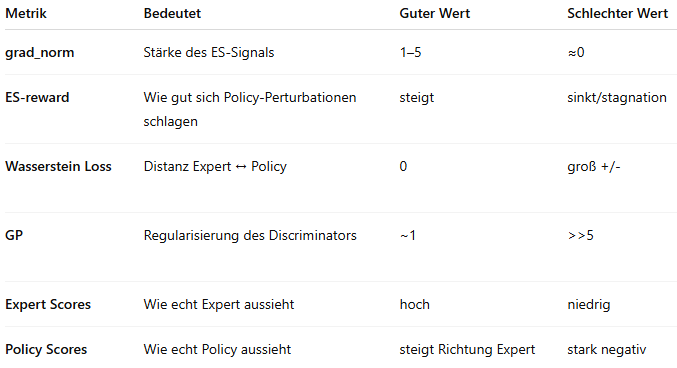